
```
Jason Adriel - 2501985451

```



# 0. Prerequisites

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import re

from tensorflow import keras
from tqdm import tqdm

# Superglobals
G_SEED = 1
SEQ_LEN = 160
BATCH_SIZE = 256
MAX_VOCAB_SIZE = 25000
EMBED_DIM = 8
NUM_ATT_HEADS = 4

# Seeding
keras.utils.set_random_seed(G_SEED)

# Library Setup
sns.set_style('whitegrid')

In [2]:
# Library Installs
!pip install contractions
!pip install keras-nlp keras-core --no-deps
!pip install tf-models-official==2.14.2
!pip install nlpaug sacremoses scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 8.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=6faafcfaac08a76ebfacfc59b05bfcb18a0a4ee88539506e2f1de40fc5b9e475

# 1. Data Preprocessing

In [3]:
# Loading the Data
df_train = pd.read_csv("https://media.githubusercontent.com/media/subtle64/Datasets/main/Kaggle/sentiment_analysis_small_train.csv", encoding = "windows-1252")
df_test = pd.read_csv("https://media.githubusercontent.com/media/subtle64/Datasets/main/Kaggle/sentiment_analysis_small_test.csv", encoding = "windows-1252")

In [4]:
df_train = df_train[['text', 'sentiment']]
df_test  = df_test[['text', 'sentiment']]

In [5]:
df_train.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [6]:
df_test.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [7]:
# Testing and removing NAs and invalid duplicates
df_train = df_train.dropna().drop_duplicates()
df_test = df_test.dropna().drop_duplicates()
print(f"NAs: {df_train.isna().sum().sum(),  df_test.isna().sum().sum()}", sep = '\n')
print(f"Duplicates: {df_train.duplicated().sum(), df_test.duplicated().sum()}", sep = '\n')

NAs: (0, 0)
Duplicates: (0, 0)


In [8]:
# The target is quite balanced
df_train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

## 1.1 Preprocessing Pipeline

In [9]:
# One thing to realize is that this data comes from Twitter,
# proper preprocessing is necessary
from nltk.tokenize.casual import TweetTokenizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
import contractions
import string
import nlpaug.augmenter.word as naw
nltk.download('wordnet')
aug = naw.SynonymAug(aug_p = 0.5)

def remove_url(text):
  return re.sub(r'http\S+', '', text)

def remove_handles(text):
  return re.sub(r'@[\w]+(:)?', '', text)

def fix_quotations(text):
  return text.replace("`", "'")

def normalize(text):
  return re.sub(' +', ' ', text)

def tokenize_twitter(text):
  tokenizer = TweetTokenizer(reduce_len=True)
  return tokenizer.tokenize(text)

def encode_censorship(text):
  return re.sub('[*]{4}', 'XXX', text)

def expand_contractions(wordlist):
  return [contractions.fix(w) for w in wordlist]

def remove_noise(wordlist):
  noise = set(string.punctuation + string.digits)
  return [w for w in wordlist if not w in noise]

def patch(wordlist):
  text =  " ".join(wordlist)
  return text.strip()

def lemmatize(wordlist):
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(w.lower()) for w in wordlist]

def label_encode(y):
  enc = LabelEncoder()
  return enc.fit_transform(y), enc.classes_

def synonymize(text):
  return aug.augment(text)[0]

def preprocess(df, x = 'text', y = 'sentiment'):
  df = df.copy()
  tqdm.pandas()
  df[x] = df[x].progress_apply(normalize)
  df[x] = df[x].progress_apply(fix_quotations)
  df[x] = df[x].progress_apply(remove_url)
  df[x] = df[x].progress_apply(remove_handles)
  df[x] = df[x].progress_apply(encode_censorship)
  df[x] = df[x].progress_apply(tokenize_twitter)
  df[x] = df[x].progress_apply(expand_contractions)
  df[x] = df[x].progress_apply(remove_noise)
  df[x] = df[x].progress_apply(lemmatize)
  df[x] = df[x].progress_apply(patch)
  df = df[df[x] != ""]
  df[y], classes = label_encode(df[y])
  return df, classes

df_preprocessed_train, train_classes = preprocess(df_train)
df_preprocessed_test, test_classes = preprocess(df_test)

[nltk_data] Downloading package wordnet to /root/nltk_data...
100%|██████████| 3534/3534 [00:00<00:00, 161231.65it/s]


In [10]:
df_preprocessed_train.head()

,text,sentiment
0,i would have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my bos is bullying me ...,0
3,what interview leave me alone,0
4,son of xxx why could not they put them on the ...,0


In [11]:
df_preprocessed_test.head()

,text,sentiment
0,last session of the day,1
1,shanghai is also really exciting precisely sky...,2
2,recession hit veronique branquinho she ha to q...,0
3,happy birthday,2
4,i like it,2


## 1.2 Data Splitting

In [12]:
# Preparing for augmentation
def augment(df, x = "text"):
  df_augment = df.copy()
  df_augment[x] = df_augment[x].progress_apply(synonymize)
  df = pd.concat([df, df_augment], ignore_index = True)
  return df


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    df_preprocessed_train['text'],
    df_preprocessed_train['sentiment'],
    test_size = 0.2,
    stratify = df_preprocessed_train['sentiment']
)

ds_train = pd.DataFrame({'text' : x_train, 'sentiment' : y_train})
ds_val   = pd.DataFrame({'text' : x_val, 'sentiment' : y_val})

# Augment ONLY on the training set
ds_train = augment(ds_train)

ds_train = tf.data.Dataset.from_tensor_slices(dict(ds_train)).batch(BATCH_SIZE)
ds_val= tf.data.Dataset.from_tensor_slices(dict(ds_val)).batch(BATCH_SIZE)
ds_test = tf.data.Dataset.from_tensor_slices(dict(df_preprocessed_test)).batch(BATCH_SIZE)

  0%|          | 0/21982 [00:00<?, ?it/s][nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
100%|██████████| 21982/21982 [00:32<00:00, 684.58it/s]


## 1.3 Re-tokenize usig the Word Piece Tokenizer

In [14]:
import keras_nlp

vocabulary = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    ds_train.map(lambda x : x['text']),
    vocabulary_size = MAX_VOCAB_SIZE,
    reserved_tokens=["[PAD]", "[CLS]", "[SEP]", "[UNK]"],
)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary = vocabulary
)

packer = keras_nlp.layers.StartEndPacker(
    start_value = tokenizer.token_to_id("[CLS]"),
    end_value = tokenizer.token_to_id("[SEP]"),
    pad_value = tokenizer.token_to_id("[PAD]"),
    sequence_length = SEQ_LEN,
)

Using TensorFlow backend


In [15]:
len(vocabulary)

6075

In [16]:
def retokenize(ds):
  return packer(tokenizer(ds['text'])), ds['sentiment']

use_train = ds_train.map(retokenize, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
use_val   = ds_val.map(retokenize, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
use_test  = ds_test.map(retokenize, num_parallel_calls = tf.data.AUTOTUNE)

In [17]:
print(use_train.take(1).get_single_element())
print(use_test.take(1).get_single_element())

(<tf.Tensor: shape=(256, 160), dtype=int32, numpy=
array([[   1,  104,  585, ...,    0,    0,    0],
       [   1,   75,   76, ...,    0,    0,    0],
       [   1,  292,  322, ...,    0,    0,    0],
       ...,
       [   1,   33,   37, ...,    0,    0,    0],
       [   1,   83,   73, ...,    0,    0,    0],
       [   1, 1992,  141, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(256,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 0, 1, 1, 2, 1, 0, 0, 2, 2, 0,
       0, 2, 2, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 2,
       0, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 2, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 2, 0, 1, 1, 0,
       2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 1, 0, 1, 2, 0,
       0, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1,
       0, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 

# 2. Modelling

In [18]:
# Creating a basic transformer model
import tensorflow_models as tfm

def get_transformer_model(vocabulary):
  # The necessary input blocks
  inputs = keras.Input(shape = (SEQ_LEN, ))
  embedding = keras_nlp.layers.TokenAndPositionEmbedding(
      vocabulary_size = len(vocabulary),
      sequence_length = SEQ_LEN,
      embedding_dim = EMBED_DIM,
      mask_zero = True,
  )(inputs)
  norm = keras.layers.LayerNormalization()(embedding)
  dropout_1 = keras.layers.Dropout(0.3)(norm)

  # The transformer encoder blocks
  t1 = tfm.nlp.layers.TransformerEncoderBlock(
      NUM_ATT_HEADS,
      128,
      'relu',
      output_dropout = 0.2,
      attention_dropout = 0.2,
      inner_dropout = 0.2,
  )(dropout_1)

  t2 = tfm.nlp.layers.TransformerEncoderBlock(
      NUM_ATT_HEADS,
      128,
      'relu',
      output_dropout = 0.2,
      attention_dropout = 0.2,
      inner_dropout = 0.2,
  )(t1)

  t3 = tfm.nlp.layers.TransformerEncoderBlock(
      NUM_ATT_HEADS,
      128,
      'relu',
      output_dropout = 0.2,
      attention_dropout = 0.2,
      inner_dropout = 0.2,
  )(t2)

  dense_1 = keras.layers.Dense(64, 'tanh')(t3[:, 0, :]) # Use the CLS token to predict.
  regularize = keras.layers.ActivityRegularization(l1 = 0.01, l2 = 0.01)(dense_1)
  dropout_2 = keras.layers.Dropout(0.2)(regularize)
  outputs = keras.layers.Dense(3, 'softmax')(dropout_2)

  return keras.Model(inputs, outputs)

model_1 = get_transformer_model(vocabulary)

In [19]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160)]             0         
                                                                 
 token_and_position_embeddi  (None, 160, 8)            49880     
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 layer_normalization (Layer  (None, 160, 8)            16        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 160, 8)            0         
                                                                 
 transformer_encoder_block   (None, 160, 8)            2504      
 (TransformerEncoderBlock)                                   

In [20]:
# Training the model
model_1.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["sparse_categorical_accuracy"],
    jit_compile = True,
)

m1_history = model_1.fit(
    use_train,
    validation_data = use_val,
    epochs = 10,
)

Epoch 1/10
172/172 [==============================] - 119s 580ms/step - loss: 1.1917 - sparse_categorical_accuracy: 0.3923 - val_loss: 1.0982 - val_sparse_categorical_accuracy: 0.4045
Epoch 2/10
172/172 [==============================] - 81s 471ms/step - loss: 1.0608 - sparse_categorical_accuracy: 0.4546 - val_loss: 0.8923 - val_sparse_categorical_accuracy: 0.6217
Epoch 3/10
172/172 [==============================] - 82s 477ms/step - loss: 0.8882 - sparse_categorical_accuracy: 0.6164 - val_loss: 0.7881 - val_sparse_categorical_accuracy: 0.6969
Epoch 4/10
172/172 [==============================] - 84s 486ms/step - loss: 0.8102 - sparse_categorical_accuracy: 0.6676 - val_loss: 0.7503 - val_sparse_categorical_accuracy: 0.7131
Epoch 5/10
172/172 [==============================] - 82s 479ms/step - loss: 0.7695 - sparse_categorical_accuracy: 0.6928 - val_loss: 0.7320 - val_sparse_categorical_accuracy: 0.7162
Epoch 6/10
172/172 [==============================] - 81s 473ms/step - loss: 0.7345 

In [30]:
from sklearn.metrics import classification_report
import scikitplot as sckp

def evaluate_training(history):
  fig, axes = plt.subplots(1, 2, figsize = (12, 4))
  graph = pd.DataFrame(history.history)
  graph.loc[:, ['loss', 'val_loss']].plot(ax = axes[0], title = "Train/Val Loss Plot")
  graph.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(ax = axes[1], title = "Train/Val Accuracy Plot")

def evaluate_model(model, test):
  y_pred = model.predict(test)
  y_test = [y.numpy() for x, y in test.unbatch()]
  print(classification_report(np.argmax(y_pred, axis = 1), y_test))
  sckp.metrics.plot_roc(y_test, y_pred)

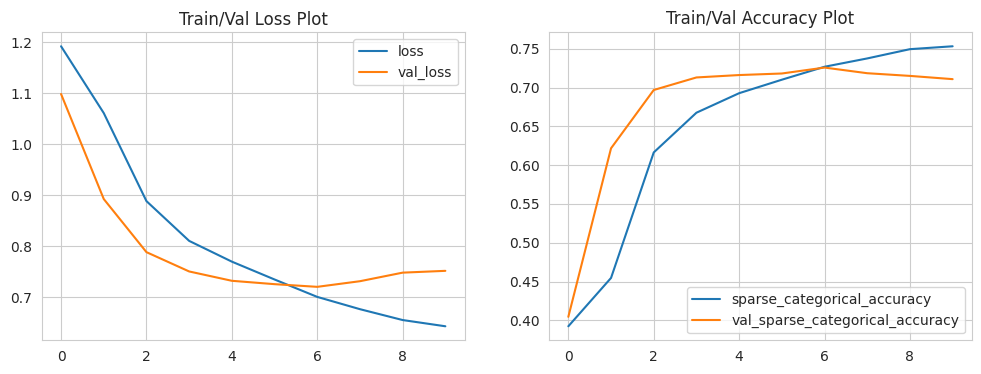

In [22]:
%matplotlib inline
evaluate_training(m1_history)

14/14 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.73      0.70      0.71      1033
           1       0.66      0.71      0.68      1321
           2       0.80      0.75      0.77      1179

    accuracy                           0.72      3533
   macro avg       0.73      0.72      0.72      3533
weighted avg       0.72      0.72      0.72      3533



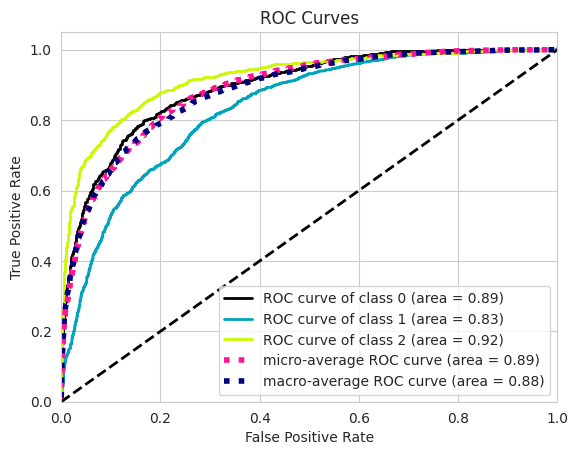

In [31]:
evaluate_model(model_1, use_test)

Sadly quite dissapointing... was hoping for a better result.
1. The model is overfitting, val_loss is stuck 0.70 and increases, whereas the loss slightly decreases over time.
2. Perhaps the greatest issue here is the variable length sequence that the data set has. Some tweets are very small in length (less than 3 words) whereas some has more than 128 words in length. Which, of course, is not ideal.
3. I tried numerous methods, from augmenting the data, adding attention dropouts (this is only available in tfm, not in keras_nlp for some reason), changing the dropout rate, all of which only contributed a small amount to the final result. I experimented with GlobalAveragePooling() or using the CLS token like BERT does, it seems like training the Transformer to concatenate the information to the CLS token is better than pooling.
4. The next thing I wanted to try is to do pretraining of the model, but if I do that, what's the difference with testing with the BERT classifier?
5. No, I didn't try like 2^16 combinations of the architecture, and no, I totally didn't run to OOM problems when trying pretrained BERT models. And no, I don't want to wait 8 hours to train with batch size of 1 with BERT. (I already got banned from Google Collab...)
6. As a side note... maybe I am approaching this problem in an overly complex way. Maybe we don't even need positional information, sentiment analysis can be done just by seeing the contents of the words. Nonetheless, let's try a simple RNN on the next run, could it perhaps be better in this simpler task?
7. The AUC (note the area legend in the ROC plot above) is quite okay, ~0.88.

In [24]:
# Creating a basic RNN model
def get_rnn_model(vocabulary):
  # The necessary input blocks
  inputs = keras.Input(shape = (SEQ_LEN, ))
  embedding = keras.layers.Embedding(
      len(vocabulary),
      512,
      mask_zero = True,
  )(inputs)
  layer_norm_1 = keras.layers.BatchNormalization()(embedding)
  dropout_1 = keras.layers.Dropout(0.3)(layer_norm_1)

  # The RNN Blocks
  rnn_1 = keras.layers.SimpleRNN(512, return_sequences=True)(dropout_1)
  rnn_2 = keras.layers.SimpleRNN(512, return_sequences=True)(rnn_1)
  rnn_3 = keras.layers.SimpleRNN(512)(rnn_2)

  #Dense Head
  dense_1 = keras.layers.Dense(32, 'tanh')(rnn_3)

  #Outputs
  outputs = keras.layers.Dense(3, activation = "softmax")(dense_1)

  return keras.Model(inputs, outputs)

model_2 = get_rnn_model(vocabulary)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160)]             0         
                                                                 
 embedding (Embedding)       (None, 160, 512)          3110400   
                                                                 
 batch_normalization (Batch  (None, 160, 512)          2048      
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 160, 512)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 160, 512)          524800    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 160, 512)          524800    
                                                           

In [25]:
# Training the model
# I tried using LSTM and GRU and somehow (I don't know why), it takes 30 minutes per epoch.
# So, no thanks.
model_2.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["sparse_categorical_accuracy"],
    jit_compile = True,
)

m2_history = model_2.fit(
    use_train,
    validation_data = use_val,
    epochs = 10,
)

Epoch 1/10
172/172 [==============================] - 116s 626ms/step - loss: 0.9562 - sparse_categorical_accuracy: 0.5440 - val_loss: 1.3708 - val_sparse_categorical_accuracy: 0.3863
Epoch 2/10
172/172 [==============================] - 99s 575ms/step - loss: 0.8003 - sparse_categorical_accuracy: 0.6463 - val_loss: 1.0981 - val_sparse_categorical_accuracy: 0.4767
Epoch 3/10
172/172 [==============================] - 97s 565ms/step - loss: 0.7686 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.8731 - val_sparse_categorical_accuracy: 0.6334
Epoch 4/10
172/172 [==============================] - 96s 557ms/step - loss: 0.7811 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.8666 - val_sparse_categorical_accuracy: 0.6157
Epoch 5/10
172/172 [==============================] - 96s 557ms/step - loss: 0.7118 - sparse_categorical_accuracy: 0.7031 - val_loss: 0.8828 - val_sparse_categorical_accuracy: 0.5961
Epoch 6/10
172/172 [==============================] - 97s 561ms/step - loss: 0.6264 

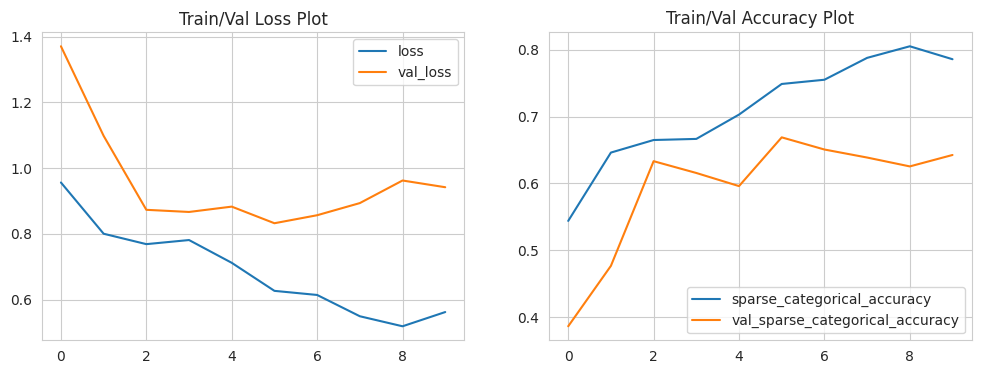

In [26]:
evaluate_training(m2_history)

14/14 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1104
           1       0.61      0.61      0.61      1431
           2       0.66      0.73      0.69       998

    accuracy                           0.64      3533
   macro avg       0.65      0.65      0.65      3533
weighted avg       0.65      0.64      0.64      3533



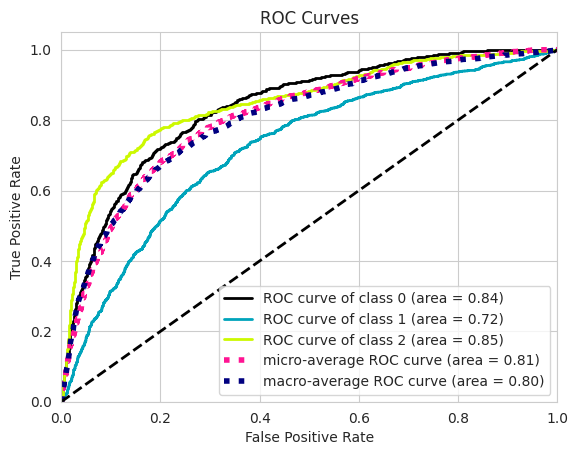

In [32]:
evaluate_model(model_2, use_test)

1. In conclusion, it is obvious that RNNs are not as good as Transformers.
2. The RNN model also succumbs to overfitting, so perhaps this is due to either my preprocessing pipeline, or the data itself.
3. Further improvements can be done, probably with better text augmentation techniques (back-translation maybe? But it's computation cost is significant).